#  Project September — Quantum Kernel SVM

This notebook explores **support vector machines (SVMs)** with two kernels:

1. **Classical RBF SVM** – baseline using a standard kernel.  
2. **Quantum Kernel SVM** – based on a fixed quantum feature map.

---

###  Goal
Compare classical and quantum kernels in terms of decision boundaries and accuracy.


##  Imports  

Set up classical ML tools, quantum modules, and utilities.  


In [70]:
# --- Core scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Classical ML (scikit-learn) ---
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Quantum tools (Qiskit) ---
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import Aer
from qiskit_machine_learning import __version__ as qml_version
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# --- Utilities ---
from numpy.random import default_rng
from pathlib import Path
from joblib import Parallel, delayed

print("Qiskit Machine Learning version:", qml_version)


Qiskit Machine Learning version: 0.8.4


## Dataset Loading & Visualization  

Load the training/test splits from `.dat` files and project them to visualize class separation.  


Current working dir: /Users/kalliopi/Desktop/quantum_kernel_svm
Files in ./data: ['class1_data_test.dat', 'class1_data_train.dat', 'class2_data_test.dat', 'class2_data_train.dat']
class1_data_train.dat exists? True
class1_data_test.dat exists? True
class2_data_train.dat exists? True
class2_data_test.dat exists? True

class1_train shape: (100, 2)
class1_train head:
           0         1
0  1.041551  0.153906
1 -0.258876  0.817340
2  0.844954  0.863584
3  0.900311  0.903320
4 -0.024829  1.233557

class2_train shape: (100, 2)
class2_train head:
           0         1
0  1.627004 -0.132771
1  0.714797 -0.621038
2  0.268819 -0.369523
3  2.142244 -0.217488
4 -0.113902  0.222940


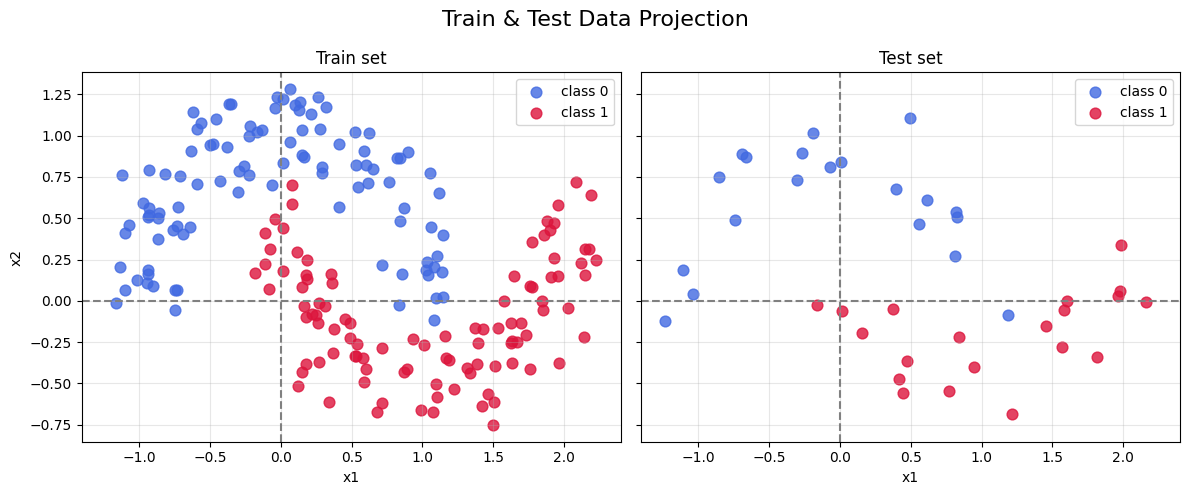

In [72]:
# --- Visualize train and test sets in 2D ---
def subplot_train_test(X_train, y_train, X_test, y_test, title="Train & Test Data Projection"):
    # Reduce to 2D if needed
    if X_train.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_train_2d = pca.fit_transform(X_train)
        X_test_2d  = pca.transform(X_test)
        xlabel, ylabel = "PC1", "PC2"
    else:
        X_train_2d, X_test_2d = X_train, X_test
        xlabel, ylabel = "x1", "x2"

    colors = {0: "royalblue", 1: "crimson"}

    # Side-by-side train/test plots
    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

    for cls in np.unique(y_train):
        mask = (y_train == cls)
        axes[0].scatter(X_train_2d[mask,0], X_train_2d[mask,1], color=colors[cls], s=60, alpha=0.8, label=f"class {cls}")
    axes[0].axhline(0, color="gray", linestyle="--")
    axes[0].axvline(0, color="gray", linestyle="--")
    axes[0].set_title("Train set")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    for cls in np.unique(y_test):
        mask = (y_test == cls)
        axes[1].scatter(X_test_2d[mask,0], X_test_2d[mask,1], color=colors[cls], s=60, alpha=0.8, label=f"class {cls}")
    axes[1].axhline(0, color="gray", linestyle="--")
    axes[1].axvline(0, color="gray", linestyle="--")
    axes[1].set_title("Test set")
    axes[1].set_xlabel(xlabel)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# --- Helper to load tab-separated data ---
def load_tab_file(path):
    return pd.read_csv(path, sep="\t", header=None)


# --- Main block: load data, assign labels, and visualize ---
RNG = np.random.default_rng(42)

print("Current working dir:", os.getcwd())
print("Files in ./data:", sorted(os.listdir("data")))

# Define paths
p_class1_train = Path("data/class1_data_train.dat")
p_class1_test  = Path("data/class1_data_test.dat")
p_class2_train = Path("data/class2_data_train.dat")
p_class2_test  = Path("data/class2_data_test.dat")

# Check files
for p in (p_class1_train, p_class1_test, p_class2_train, p_class2_test):
    print(p.name, "exists?", p.exists())

# Load datasets
df1_train = load_tab_file(p_class1_train)
df1_test  = load_tab_file(p_class1_test)
df2_train = load_tab_file(p_class2_train)
df2_test  = load_tab_file(p_class2_test)

# Quick inspection
print("\nclass1_train shape:", df1_train.shape)
print("class1_train head:\n", df1_train.head())
print("\nclass2_train shape:", df2_train.shape)
print("class2_train head:\n", df2_train.head())

# Combine into X, y arrays
df1_train["y"] = 0
df2_train["y"] = 1
df_train = pd.concat([df1_train, df2_train], ignore_index=True)

df1_test["y"] = 0
df2_test["y"] = 1
df_test = pd.concat([df1_test, df2_test], ignore_index=True)

X_train = df_train.drop(columns=["y"]).values
y_train = df_train["y"].values
X_test  = df_test.drop(columns=["y"]).values
y_test  = df_test["y"].values

# Visualize the train/test distributions
subplot_train_test(X_train, y_train, X_test, y_test)


### Classical RBF SVM Exploration

Train and evaluate **RBF SVMs** with different `C` and `gamma` parameters.  




Parameters: C=1, gamma=scale
Train accuracy: 0.98
Test accuracy : 0.975
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40


Parameters: C=0.1, gamma=0.1
Train accuracy: 0.83
Test accuracy : 0.85
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.82      0.90      0.86        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40


Parameters: C=100.0, gamma=10.0
Train accuracy: 1.0
Test accuracy : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       

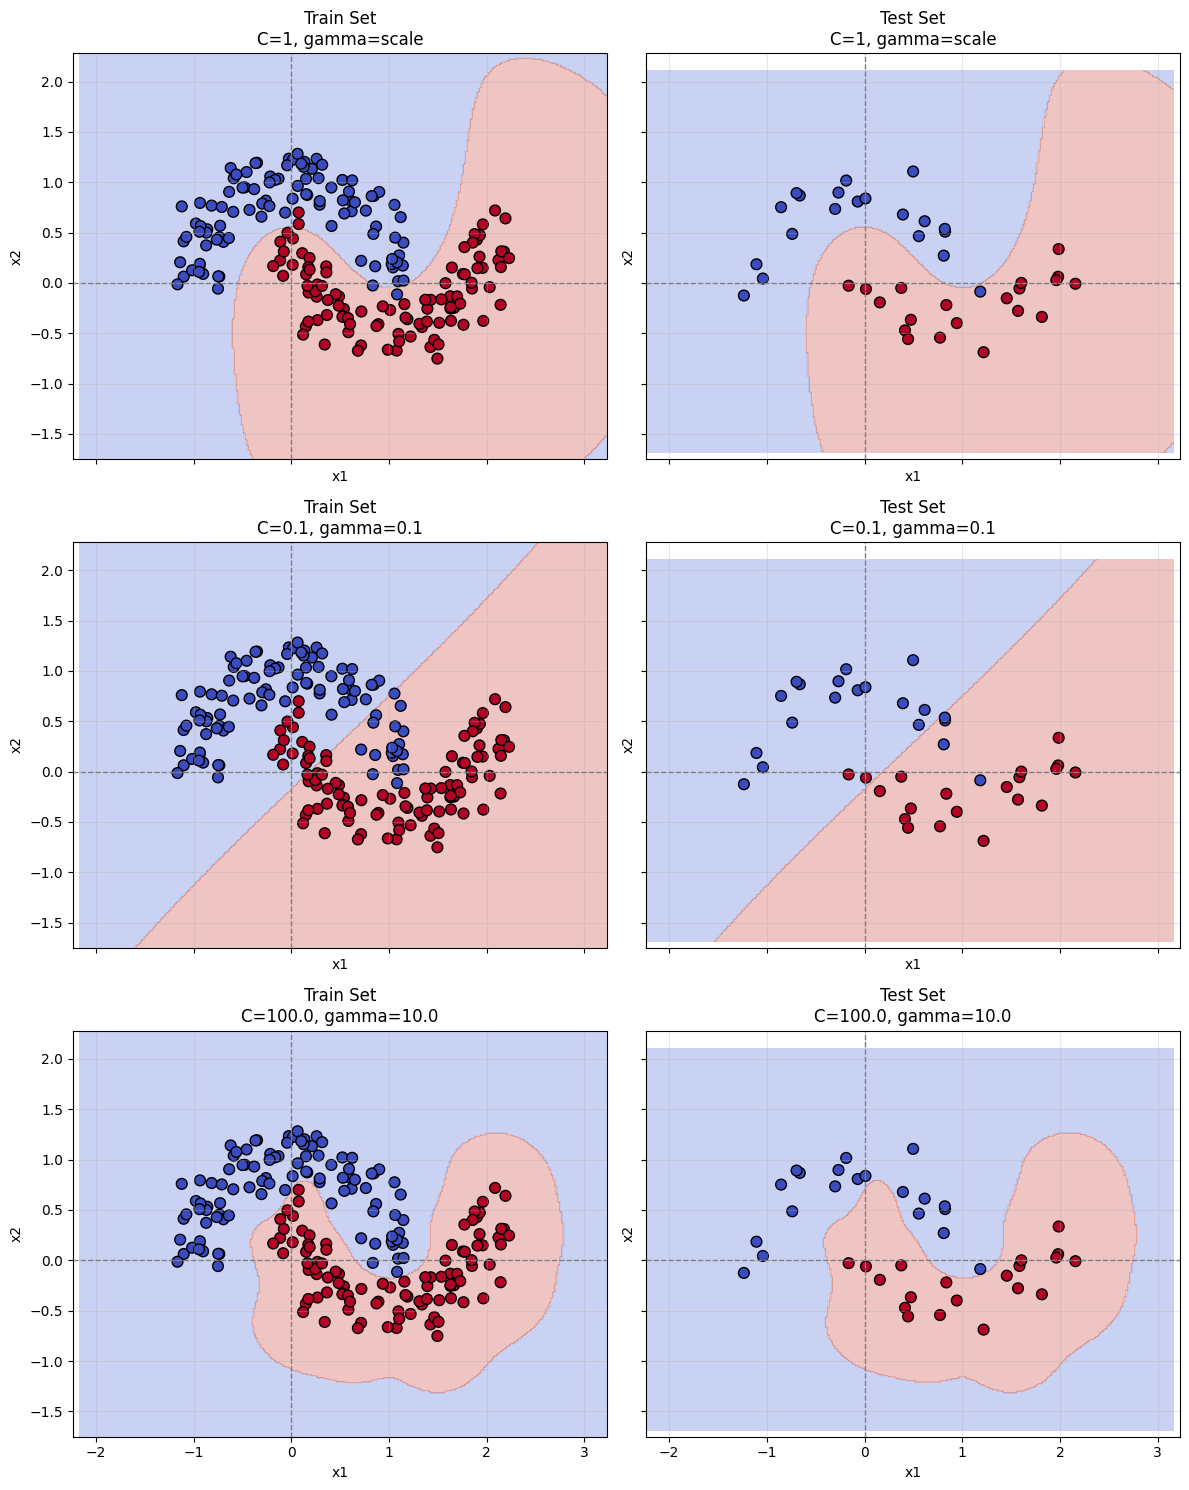

In [74]:
# --- Function to plot decision boundaries ---
def plot_decision_boundaries(X, y, clf, ax, title="Decision Boundary"):
    # Reduce to 2D using PCA if more than 2 features
    if X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(X)
    else:
        X2 = X

    xlabel, ylabel = ("PC1", "PC2") if X.shape[1] > 2 else ("x1", "x2")

    # Create grid for contour plot
    x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
    y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Predict on grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot contour and data points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X2[:,0], X2[:,1], c=y, cmap=plt.cm.coolwarm, s=60, edgecolor="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(alpha=0.3)


# --- SVM hyperparameter sets ---
params = [
    {"C": 1, "gamma": "scale"},
    {"C": 0.1, "gamma": 0.1},
    {"C": 100.0, "gamma": 10.0}
]

# --- Subplots for train/test with different params ---
fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, param in enumerate(params):
    # Train SVM on training data
    clf = SVC(kernel="rbf", C=param["C"], gamma=param["gamma"], random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate on train and test
    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)
    print(f"\nParameters: C={param['C']}, gamma={param['gamma']}")
    print("Train accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test accuracy :", accuracy_score(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    
    # Plot decision boundaries
    plot_decision_boundaries(X_train, y_train, clf, axes[i, 0], 
                             f"Train Set\nC={param['C']}, gamma={param['gamma']}")
    plot_decision_boundaries(X_test, y_test, clf, axes[i, 1], 
                             f"Test Set\nC={param['C']}, gamma={param['gamma']}")

plt.tight_layout()
plt.show()


# Quantum Kernel SVM — Inversion Routine

Encode classical data into quantum states, build a quantum kernel and train an SVM using it.


Computing training kernel matrix...
Computing test kernel matrix...
Quantum Kernel SVM (Inversion Routine using Statevector)
Train accuracy: 0.875
Test accuracy : 0.95

Classification report (test set):
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



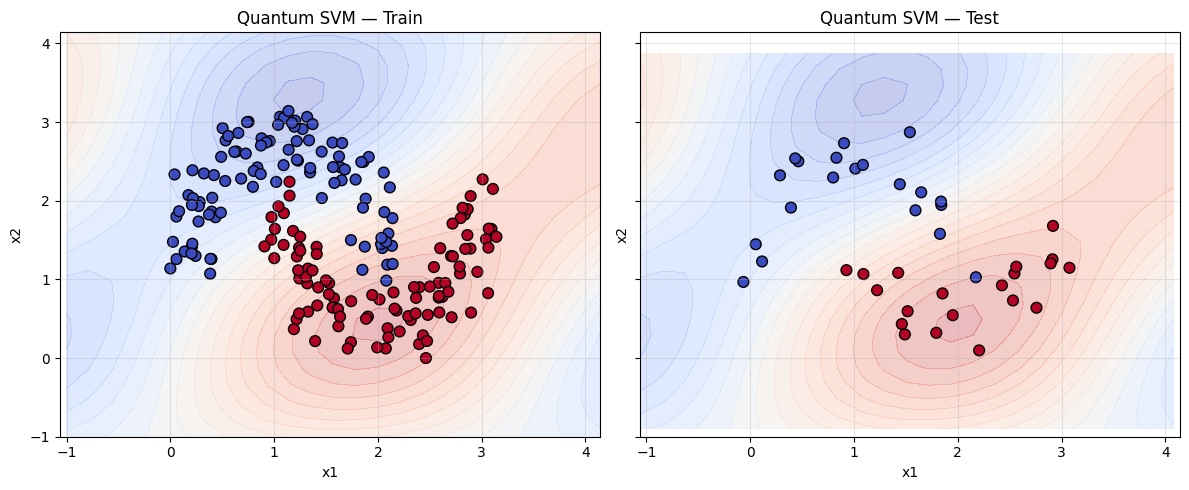

In [77]:
# --- Encode classical data into quantum states ---
def encode_data(x):
    """Encode a classical feature vector into a quantum circuit with RY rotations."""
    num_qubits = len(x)
    qc = QuantumCircuit(num_qubits)
    for i, val in enumerate(x):
        qc.ry(val, i)
    return qc

# --- Quantum kernel via inversion using Statevector ---
def quantum_kernel_inversion(x, y):
    """Compute kernel as probability of returning to |0>^n after circuit inversion."""
    Ux = encode_data(x)
    Uy = encode_data(y)
    circ = Ux.inverse().compose(Uy)
    state = Statevector.from_instruction(circ)
    return np.abs(state.data[0])**2

# --- Build kernel matrix for a dataset pair ---
def build_kernel_matrix(X1, X2):
    """Construct the full quantum kernel matrix between two datasets."""
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = quantum_kernel_inversion(X1[i], X2[j])
    return K

# --- Plot quantum SVM decision boundaries ---
def plot_quantum_decision_boundaries(X, y, clf, title="Quantum SVM Decision Boundary"):
    """Plot decision regions for quantum SVM, reducing to 2D with PCA if needed."""
    if X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X2 = pca.fit_transform(X)
    else:
        X2 = X

    # Create a mesh grid over 2D space
    x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
    y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 25),
                         np.linspace(y_min, y_max, 25))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Map back to full feature space if PCA was applied
    if X.shape[1] > 2:
        grid_points_full = pca.inverse_transform(grid_points)
    else:
        grid_points_full = grid_points

    # Compute quantum kernel for the grid points
    K_grid = build_kernel_matrix(grid_points_full, X_train_scaled)
    Z = clf.decision_function(K_grid).reshape(xx.shape)

    # Plot contours and data points
    plt.contourf(xx, yy, Z, levels=20, cmap=plt.cm.coolwarm, alpha=0.3)
    plt.scatter(X2[:,0], X2[:,1], c=y, cmap=plt.cm.coolwarm, s=60, edgecolor="k")
    plt.xlabel("PC1" if X.shape[1] > 2 else "x1")
    plt.ylabel("PC2" if X.shape[1] > 2 else "x2")
    plt.title(title)
    plt.grid(alpha=0.3)

# --- Scale features to [0, pi] for RY rotations ---
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Compute quantum kernel matrices ---
print("Computing training kernel matrix...")
K_train = build_kernel_matrix(X_train_scaled, X_train_scaled)

print("Computing test kernel matrix...")
K_test = build_kernel_matrix(X_test_scaled, X_train_scaled)

# --- Train SVM with precomputed quantum kernel ---
qsvc = SVC(kernel='precomputed')
qsvc.fit(K_train, y_train)

# --- Evaluate quantum SVM performance ---
y_pred_train = qsvc.predict(K_train)
y_pred_test  = qsvc.predict(K_test)

print("Quantum Kernel SVM (Inversion Routine using Statevector)")
print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy :", accuracy_score(y_test, y_pred_test))
print("\nClassification report (test set):\n", classification_report(y_test, y_pred_test))

# --- Plot decision boundaries side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
plt.sca(axes[0])
plot_quantum_decision_boundaries(X_train_scaled, y_train, qsvc, "Quantum SVM — Train")
plt.sca(axes[1])
plot_quantum_decision_boundaries(X_test_scaled, y_test, qsvc, "Quantum SVM — Test")
plt.tight_layout()
plt.show()
